<a href="https://colab.research.google.com/github/n0gaa/oscillating_mindfully/blob/main/Oscillating_Mindfully.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

imports

In [40]:
!pip install scikit-learn --upgrade
!pip install numpy
!pip install tensorflow==2.3
!pip install mne
!pip install shap

import numpy as np
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

drive.mount('/content/gdrive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [41]:
# define CONSTS
K = 2
top_features_count = 10

labels_file_path = "/content/gdrive/My Drive/FA Research/processed/labels_ht_vip_ext.txt"
x_test_file_path = '/content/gdrive/My Drive/FA Research/models/XGBoost/x_test.csv'
y_test_file_path = '/content/gdrive/My Drive/FA Research/models/XGBoost/y_test.npy'
x_train_file_path = '/content/gdrive/My Drive/FA Research/models/XGBoost/x_train.csv'
y_train_file_path = '/content/gdrive/My Drive/FA Research/models/XGBoost/y_train.npy'

all_features = ['delta_fp1','delta_fpz','delta_fp2','delta_af3','delta_afz','delta_af4','delta_f1','delta_fz','delta_f2',
                                             'theta_fp1','theta_fpz','theta_fp2','theta_af3','theta_afz','theta_af4','theta_f1','theta_fz','theta_f2',
                                             'alpha_fp1','alpha_fpz','alpha_fp2','alpha_af3','alpha_afz','alpha_af4','alpha_f1','alpha_fz','alpha_f2',
                                             'beta_fp1','beta_fpz','beta_fp2','beta_af3','beta_afz','beta_af4','beta_f1','beta_fz','beta_f2',
                                             'gamma_fp1','gamma_fpz','gamma_fp2','gamma_af3','gamma_afz','gamma_af4','gamma_f1','gamma_fz','gamma_f2',
                                             'c01_delta','c01_theta','c01_alpha','c01_beta','c01_gamma',
                                             'c02_delta','c02_theta','c02_alpha','c02_beta','c02_gamma',
                                             'c03_delta','c03_theta','c03_alpha','c03_beta','c03_gamma',
                                             'c04_delta','c04_theta','c04_alpha','c04_beta','c04_gamma',
                                             'c05_delta','c05_theta','c05_alpha','c05_beta','c05_gamma',
                                             'c06_delta','c06_theta','c06_alpha','c06_beta','c06_gamma',
                                             'c07_delta','c07_theta','c07_alpha','c07_beta','c07_gamma',
                                             'c08_delta','c08_theta','c08_alpha','c08_beta','c08_gamma',
                                             'c12_delta','c12_theta','c12_alpha','c12_beta','c12_gamma',
                                             'c13_delta','c13_theta','c13_alpha','c13_beta','c13_gamma',
                                             'c14_delta','c14_theta','c14_alpha','c14_beta','c14_gamma',
                                             'c15_delta','c15_theta','c15_alpha','c15_beta','c15_gamma',
                                             'c16_delta','c16_theta','c16_alpha','c16_beta','c16_gamma',
                                             'c17_delta','c17_theta','c17_alpha','c17_beta','c17_gamma',
                                             'c18_delta','c18_theta','c18_alpha','c18_beta','c18_gamma',
                                             'c23_delta','c23_theta','c23_alpha','c23_beta','c23_gamma',
                                             'c24_delta','c24_theta','c24_alpha','c24_beta','c24_gamma',
                                             'c25_delta','c25_theta','c25_alpha','c25_beta','c25_gamma',
                                             'c26_delta','c26_theta','c26_alpha','c26_beta','c26_gamma',
                                             'c27_delta','c27_theta','c27_alpha','c27_beta','c27_gamma',
                                             'c28_delta','c28_theta','c28_alpha','c28_beta','c28_gamma',
                                             'c34_delta','c34_theta','c34_alpha','c34_beta','c34_gamma',
                                             'c35_delta','c35_theta','c35_alpha','c35_beta','c35_gamma',
                                             'c36_delta','c36_theta','c36_alpha','c36_beta','c36_gamma',
                                             'c37_delta','c37_theta','c37_alpha','c37_beta','c37_gamma',
                                             'c38_delta','c38_theta','c38_alpha','c38_beta','c38_gamma',
                                             'c45_delta','c45_theta','c45_alpha','c45_beta','c45_gamma',
                                             'c46_delta','c46_theta','c46_alpha','c46_beta','c46_gamma',
                                             'c47_delta','c47_theta','c47_alpha','c47_beta','c47_gamma',
                                             'c48_delta','c48_theta','c48_alpha','c48_beta','c48_gamma',
                                             'c56_delta','c56_theta','c56_alpha','c56_beta','c56_gamma',
                                             'c57_delta','c57_theta','c57_alpha','c57_beta','c57_gamma',
                                             'c58_delta','c58_theta','c58_alpha','c58_beta','c58_gamma',
                                             'c67_delta','c67_theta','c67_alpha','c67_beta','c67_gamma',
                                             'c68_delta','c68_theta','c68_alpha','c68_beta','c68_gamma',
                                             'c78_delta','c78_theta','c78_alpha','c78_beta','c78_gamma']

Get Labels

In [42]:
def get_y_no_breath():
  labels = np.loadtxt(labels_file_path, dtype=str)
  labels_dict = {'HT_breath': 0, 'HT_medit': 0, 'HT_think': 1, 
                 'VIP_breath': 0, 'VIP_medit': 0, 'VIP_think': 1}

  y = []
  for label in labels:
    y.append(labels_dict.get(label))

  y_arr = np.array(y)
  (l,c) = np.unique(y_arr, return_counts=True)
  print(l,c)

  return y_arr

In [43]:
def get_y():
  labels = np.loadtxt(labels_file_path, dtype=str)
  
  labels_dict = {'HT_breath': 2, 'HT_medit': 0, 'HT_think': 1, 
                 'VIP_breath': 2, 'VIP_medit': 0, 'VIP_think': 1}

  y = []
  for label in labels:
    y.append(labels_dict.get(label))

  y_arr = np.array(y)
  (l,c) = np.unique(y_arr, return_counts=True)
  print(l,c)

  return y_arr

Get Data

In [44]:
def get_raw_epochs():
  electrodes = ['Fp1','Fpz','Fp2','AF3','AFz','AF4','F1','Fz','F2']
  path = "/content/gdrive/My Drive/FA Research/processed/"
  file_suffix = "_epochs_matrix_ht_vip_ext.npy"
  raw_epochs = []

  for e in electrodes:
    print("loading data from file: " + path + e + file_suffix)
    raw_epochs.append(np.load(path + e + file_suffix))

  raw_epochs_all = np.dstack(raw_epochs)
  print(raw_epochs_all.shape)
  raw_epochs_all_transposed_expanded = np.expand_dims(raw_epochs_all, axis=3)
  print(raw_epochs_all_transposed_expanded.shape)

  return raw_epochs_all_transposed_expanded

Get Subjects

In [45]:
def getSubjects():
  import csv
  sub = []

  with open("/content/gdrive/My Drive/FA Research/processed/_metadata_ht_vip_ext.csv", newline='') as metadata:
    reader = csv.reader(metadata)
    for row in reader:
      if(row):
        epochs = int(row[2])
        for i in range(0,epochs):
          sub.append(row[0])
  
  return sub

In [46]:
import random

def getCalibrationIndices(test_sub):
  y_comp = get_y()
  sub = getSubjects()
  cal_idx = []

  for t_sub in test_sub: # go over each test subject to add calibration epochs
    idx = np.where(np.isin(sub,t_sub))[0] # get indices of current subject epochs within test set
    labels = y_comp[idx] # get labels of current subject epochs
    
    for cond in set(labels):
      if cond in[2]: #breath
        cond_idx = np.where(np.isin(labels,cond))[0]
        cal_start_idx = cond_idx[0]
        cal_end_idx = cond_idx[0] + int((cond_idx.shape[0])*0.7) # add first 70% of breath epochs to training set for calibration
        cal_idx.append(idx[cal_start_idx:cal_end_idx])
      elif cond in [1]: #think
        cond_idx = np.where(np.isin(labels,cond))[0]
        cal_start_idx = cond_idx[0]
        cal_end_idx = cond_idx[0] + int((cond_idx.shape[0])*0.3) # add first 30% of MW epochs to training set for calibration
        cal_idx.append(idx[cal_start_idx:cal_end_idx])

  cal_idx = [item for sublist in cal_idx for item in sublist] # flatten nested list
  print(f"Found {len(cal_idx)} epochs for calibration")

  random.shuffle(cal_idx)

  return cal_idx

################## MODEL COMPUTATIONS ####################

In [47]:
import scipy
from scipy import signal

def butter_bandstop_filter(data, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = scipy.signal.butter(order, [low, high], btype='bandstop')
    y = scipy.signal.filtfilt(b, a, data, axis=2)
    return y

In [48]:
def getFreqBand(epochs,min_freq,max_freq):
  freq = np.zeros(shape=(epochs.shape[0],epochs.shape[2]))
  i=0
  while i < epochs.shape[0]:
    j=0
    while j < epochs.shape[2]:
      f, Pxx = scipy.signal.periodogram(epochs[i,:,j,0], fs=256)

      ind_min = np.argmax(f > min_freq) - 1
      ind_max = np.argmax(f > max_freq) - 1
      freqPower = np.trapz(Pxx.flatten()[ind_min: ind_max], f[ind_min: ind_max])
      freq[i][j] = freqPower
      j=j+1
    i=i+1
   
  return freq

In [49]:
def getAlphaFreq(epochs):
  return getFreqBand(epochs,8,12)

In [50]:
def getThetaFreq(epochs):
  return getFreqBand(epochs,4,8)

In [51]:
def getDeltaFreq(epochs):
  return getFreqBand(epochs,1,4)

In [52]:
def getBetaFreq(epochs):
  return getFreqBand(epochs,12,30)

In [53]:
def getGammaFreq(epochs):
  return getFreqBand(epochs,30,150)

In [54]:
from statistics import mean 

def getCoherence(epochs,electrodes):
  coherence = np.zeros(shape=(epochs.shape[0],5))

  i=0
  while i < epochs.shape[0]:
    f,c = signal.coherence(epochs[i,:,electrodes[0],0],epochs[i,:,electrodes[1],0], fs=256)
    deltaC = mean(c[:4])
    thetaC = mean(c[4:8])
    alphaC = mean(c[8:12])
    betaC = mean(c[12:30])
    gammaC = mean(c[30:150])
    coherence[i][0] = deltaC
    coherence[i][1] = thetaC
    coherence[i][2] = alphaC
    coherence[i][3] = betaC
    coherence[i][4] = gammaC
  
    i=i+1
  return coherence

In [55]:
import pandas as pd
from itertools import combinations

def getFeaturesForEpochs(epochs):
  delta = getDeltaFreq(epochs)
  print(f"shape of power: {delta.shape}")
  theta = getThetaFreq(epochs)
  alpha = getAlphaFreq(epochs)
  beta = getBetaFreq(epochs)
  gamma = getGammaFreq(epochs)
  coherences = []

  for combo in combinations(range(9), 2):
    coherences.append(getCoherence(epochs, combo))

  x_features = np.hstack((delta,theta,alpha,beta,gamma, *coherences))
  df = pd.DataFrame(data=x_features,columns=all_features)
  print(f"all features computed for epochs: {x_features.shape}, result is df of shape: {df.shape}")
  
  return df

In [56]:
from sklearn.preprocessing import Normalizer,StandardScaler

def standardize(x_train, x_test):
  transformer = StandardScaler().fit(x_train)
  x_train_sc = transformer.transform(x_train)
  x_test_sc = transformer.transform(x_test)
  x_train_sc = pd.DataFrame(x_train_sc, columns = x_train.columns)
  x_test_sc = pd.DataFrame(x_test_sc, columns = x_test.columns)

  return x_train_sc, x_test_sc

In [57]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(100,100))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
    

In [58]:
def printShapFeaturePattern(shap_values, feature):
  shap.plots.scatter(shap_values[:,feature], color=None, ymin=-1, ymax=1)

In [59]:
import xgboost as xgb
import shap

def printTopFeatures(model, x_test_features_standardized):
  # XGBoost
  xgb.plot_importance(model,importance_type='gain', max_num_features=10)
  plt.figure(figsize = (100, 100))
  plt.show()

  # SHAP
  explainer = shap.Explainer(model)
  shap_values = explainer(x_test_features_standardized)
  shap.plots.beeswarm(shap_values,max_display=15)

In [60]:
def getXgboostImportances(model):
  xgb_importances = model.get_booster().get_score()
  xgb_importances = dict(sorted(xgb_importances.items(), key=lambda item: item[1], reverse=True))

  return xgb_importances

In [61]:
import shap

def getShapImportances(model, x_test_features_standardized):
  explainer = shap.Explainer(model)
  shap_values = explainer(x_test_features_standardized)
  feature_names = shap_values.feature_names
  shap_df = pd.DataFrame(shap_values.values, columns=feature_names)
  vals = np.abs(shap_df.values).mean(0)
  shap_importances = pd.DataFrame(list(zip(feature_names, vals)), columns=['col_name', 'feature_importance_vals'])
  shap_importances.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
  shap_importances = shap_importances.tail(shap_importances.shape[0] -1)

  return shap_importances

In [62]:
from sklearn.inspection import permutation_importance

def getPermutationImportances(model, x_test, y_test, metric):
  perm_importances = permutation_importance(model, x_test, y_test, scoring=metric)
  sorted_idx = perm_importances.importances_mean.argsort()
  perm_importance_dict = dict(zip(x_test.columns[sorted_idx][::-1],perm_importances.importances_mean[sorted_idx][::-1]))

  return perm_importance_dict

In [63]:
def scaleFeatures(x_train, x_test):
  print(x_train.shape)
  print(x_test.shape)
  x_test_scaled = np.zeros((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
  x_test_scaled[:] = x_test*1e6
  x_train_scaled = np.zeros((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
  x_train_scaled[:] = x_train*1e6

  return x_train_scaled, x_test_scaled

In [64]:
def shuffleTrainingSet(x_train, y_train, train_subjects):
  train = list(zip(x_train, y_train, train_subjects))
  random.shuffle(train)
  x_train, y_train, train_subjects = zip(*train)
  x_train = np.array(x_train)
  y_train = np.array(y_train)

  return x_train, y_train

In [65]:
from sklearn.metrics import confusion_matrix

def printConfusionMatrix(y_true, y_pred):
  labels = ['medit', 'think']
  cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
  cm = cm.astype(float)
  cm_dict = {}
  df1 = pd.DataFrame(cm, columns=labels, index=labels)
  df2 = pd.DataFrame(cm/cm.sum(axis=1)[:,None], columns=labels, index=labels)
  fig = plt.figure(figsize = (10,7))
  sns.heatmap(df2, annot=True, fmt=".2f", cmap="summer")
  fig.show()

In [66]:
from sklearn.metrics import RocCurveDisplay

def printRocCurve(y_true, y_pred):
  display = RocCurveDisplay.from_predictions(y_true, y_pred)
  display.plot()
  plt.show()

In [67]:
import random

def splitSetsBySubjects():
  sub = getSubjects()
  sub_set = list(set(sub))
  print(f"total subjects: {sub_set}")
  
  random.shuffle(sub_set)
  sub_split = np.split(sub_set, [int(len(sub_set)*0.2)])
  test_sub = sub_split[0]
  print(f"Test subjects: {test_sub}")
  train_sub_min = sub_split[1]
  train_index = [i for i, x in enumerate(sub) if x in train_sub_min]
  train_sub = [x for i, x in enumerate(sub) if i in train_index]   
  print(f"training subjects: {train_sub}")

  return train_sub, test_sub

In [68]:
def getTrainingTestingSets():
  sub = getSubjects()
  train_sub, test_sub = splitSetsBySubjects()
  
  train_indices = [i for i, x in enumerate(sub) if x in train_sub]
  test_indices = [i for i, x in enumerate(sub) if x in test_sub]
  calibration_indices = getCalibrationIndices(test_sub)

  x_comp = get_raw_epochs()
  y_comp = get_y()

  #add calibration epochs of test subjects to training set
  y_total = get_y_no_breath()
  x_train = np.array([x for i, x in enumerate(x_comp) if (i in train_indices) or i in calibration_indices])
  x_test = np.array([x for i, x in enumerate(x_comp) if i in test_indices and i not in calibration_indices])
  y_train = np.array([x for i, x in enumerate(y_total) if (i in train_indices) or i in calibration_indices])
  y_test = np.array([x for i, x in enumerate(y_total) if i in test_indices and i not in calibration_indices])

  return x_train, x_test, y_train, y_test, train_sub

In [69]:
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, f1_score

def computeScores(y_true, y_pred):
  # calculate model performance scores
  f1 = f1_score(y_true,y_pred)
  acc = accuracy_score(y_true, y_pred, normalize=True, sample_weight=None)
  roc_auc = roc_auc_score(y_true, y_pred)
  
  # print visuals for model performance
  printRocCurve(y_true, y_pred)
  printConfusionMatrix(y_true, y_pred)

  return acc, roc_auc, f1

In [70]:
import xgboost as xgb
from xgboost import XGBClassifier

def getModel():
  return xgb.XGBClassifier(n_jobs=20,objective='binary:logistic', 
                                learning_rate=0.2, gamma=2, max_depth=10,
                                colsample_bytree=1, min_child_weight=5, 
                                subsample=0.8)

In [71]:
from sklearn.utils.class_weight import compute_sample_weight

def trainModel(model, x_train, y_train):
  weights = compute_sample_weight(class_weight='balanced',y=y_train)
  model.fit(x_train, y_train, sample_weight=weights)

  return model

In [72]:
def runXgboost():  
  x_train, x_test, y_train, y_test, train_sub = getTrainingTestingSets()

  # prepare features for training
  x_train_scaled, x_test_scaled = scaleFeatures(x_train, x_test)
  x_train_scaled, y_train = shuffleTrainingSet(x_train_scaled, y_train, train_sub)
  x_train_features = getFeaturesForEpochs(x_train_scaled)
  x_test_features = getFeaturesForEpochs(x_test_scaled)
  x_train_standardized, x_test_standardized = standardize(x_train_features, x_test_features)
  x_test_standardized.to_csv(x_test_file_path, index=False, encoding='utf-8-sig')
  x_train_standardized.to_csv(x_train_file_path, index=False, encoding='utf-8-sig')
  np.save(y_test_file_path, y_test)
  np.save(y_train_file_path, y_train)

  print("Train data shape:", x_train_standardized.shape, y_train.shape, 
        "\nTest data shape:", x_test_standardized.shape, y_test.shape)

  #XGBOOST create classifier
  xgb_model = getModel()
  xgb_model = trainModel(xgb_model, x_train_standardized, y_train)

  y_pred = xgb_model.predict(x_test_standardized)

  acc, roc_auc, f1 = computeScores(y_test, y_pred)
  printTopFeatures(xgb_model, x_test_standardized)

  # calculate importacnes for features
  xgboost_importances = getXgboostImportances(xgb_model)
  shap_importances = getShapImportances(xgb_model, x_test_standardized)
  perm_importance_dict_roc = getPermutationImportances(xgb_model, x_test_standardized, y_test, "roc_auc")
  perm_importance_dict_f1 = getPermutationImportances(xgb_model, x_test_standardized, y_test, "f1")

  # call printShapFeaturePattern() here to print out SHAP graphs for specific features

  return (acc,roc_auc,f1,xgboost_importances,shap_importances,perm_importance_dict_roc,perm_importance_dict_f1)

In [73]:
def addImportantFeature(cur_list, weighted_scores, feature_index, top_features_count):
  if cur_list in weighted_scores:
    weighted_scores[cur_list] = weighted_scores[cur_list] + (top_features_count-feature_index)
  else:
    weighted_scores[cur_list] = (top_features_count-feature_index)

In [74]:
def printAggregatedScores(acc_scores, auc_scores, f1_scores):
  print("Aggregated scores after K-fold")
  print(f"AVG ACC SCORE: {statistics.mean(acc_scores)}, full scores: {acc_scores}")
  print(f"AVG AUC-ROC SCORE: {statistics.mean(auc_scores)}, full scores: {auc_scores}")
  print(f"AVG F1 SCORE: {statistics.mean(f1_scores)}, full scores: {f1_scores}")

In [75]:
def sumFeatureImportances(xgb_scores, shap_scores, roc_scores, f1_scores):
  print("########### XGBOOST #############")
  xgb_scores = dict(sorted(xgb_scores.items(), key=lambda item: item[1], reverse=True))
  print(xgb_scores)
  print("########### SHAP #############")
  shap_scores = dict(sorted(shap_scores.items(), key=lambda item: item[1], reverse=True))
  print(shap_scores)
  print("########### PERMUTATION ROC #############")
  roc_scores = dict(sorted(roc_scores.items(), key=lambda item: item[1], reverse=True))
  print(roc_scores)
  print("########### PERMUTATION F1 #############")
  f1_scores = dict(sorted(f1_scores.items(), key=lambda item: item[1], reverse=True))
  print(f1_scores)

  features = set([k for k in set(xgb_scores) | set(shap_scores) | set(roc_scores) | set(f1_scores)])
  scores_total = {f: (xgb_scores.get(f, 0) + shap_scores.get(f, 0) + roc_scores.get(f, 0) + f1_scores.get(f, 0)) for f in features}
  scores_total = {k: v for k, v in sorted(scores_total.items(), key=lambda item: item[1], reverse=True)}

  print("Summed Feature Importances:")
  print(scores_total)

  return scores_total

In [76]:
def testDimensionalityReduction(summed_importances):
  auc_scores_dimension_reduction = []
  f1_scores_dimension_reduction = []
  acc_scores_dimension_reduction = []
  top_features = dict(list(summed_importances.items())[:top_features_count]).keys()
  other_features = list(set(all_features) - set(top_features))

  for i in range(K):
    x_train_dimension_reduction = pd.read_csv(x_train_file_path).drop(labels=other_features,axis=1)
    y_train_dimension_reduction = np.load(y_train_file_path)
    x_test_dimension_reduction = pd.read_csv(x_test_file_path).drop(labels=other_features,axis=1)
    y_test_dimension_reduction = np.load(y_test_file_path)
    
    model_dimension_reduction = getModel()
    model_dimension_reduction = trainModel(model_dimension_reduction, x_train_dimension_reduction, y_train_dimension_reduction)
    y_pred_dimension_reduction = model_dimension_reduction.predict(x_test_dimension_reduction)
    acc_dimension_reduction, roc_auc_dimension_reduction, f1_dimension_reduction = computeScores(y_test_dimension_reduction, y_pred_dimension_reduction)

    acc_scores_dimension_reduction.append(acc_dimension_reduction)
    auc_scores_dimension_reduction.append(roc_auc_dimension_reduction)
    f1_scores_dimension_reduction.append(f1_dimension_reduction)

  print("******* Dimensinality Reduction Results for ", top_features_count, "Top Features: ", top_features)
  printAggregatedScores(acc_scores_dimension_reduction,auc_scores_dimension_reduction,f1_scores_dimension_reduction)

~~~~~~ running model for iteration #0 ~~~~~~
total subjects: ['VIP2', 'HT8', 'HT20', 'VIP12', 'VIP5', 'HT24', 'VIP16', 'HT25', 'VIP13', 'HT15', 'VIP19', 'HT13', 'VIP7', 'HT7', 'HT26', 'VIP3', 'VIP06', 'VIP1', 'HT18', 'HT1', 'VIP11', 'HT6', 'HT9', 'VIP15', 'VIP14', 'VIP20']
Test subjects: ['VIP06' 'HT18' 'HT24' 'VIP3' 'HT20']
training subjects: ['HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT15', 'HT15

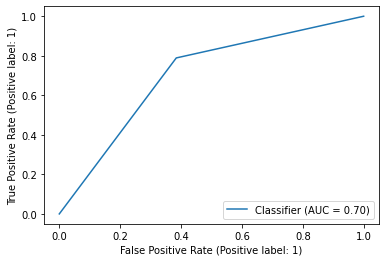

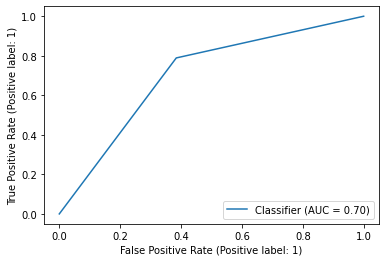

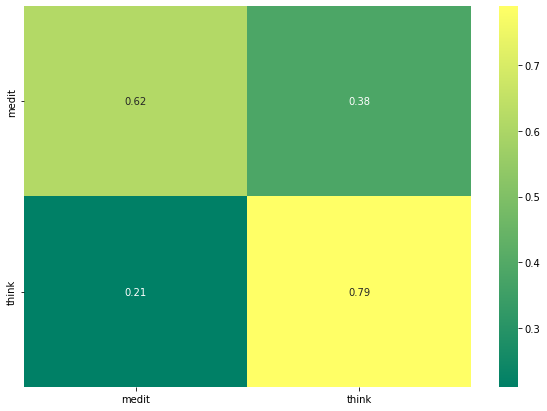

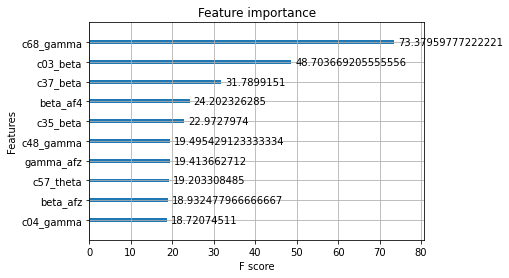

<Figure size 7200x7200 with 0 Axes>

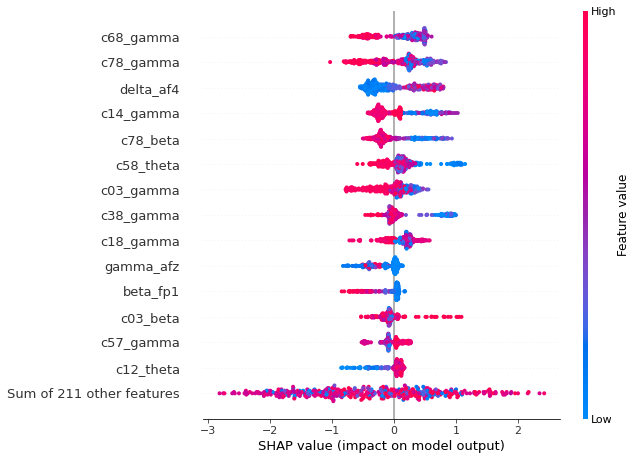

~~~~~~ running model for iteration #1 ~~~~~~
total subjects: ['VIP2', 'HT8', 'HT20', 'VIP12', 'VIP5', 'HT24', 'VIP16', 'HT25', 'VIP13', 'HT15', 'VIP19', 'HT13', 'VIP7', 'HT7', 'HT26', 'VIP3', 'VIP06', 'VIP1', 'HT18', 'HT1', 'VIP11', 'HT6', 'HT9', 'VIP15', 'VIP14', 'VIP20']
Test subjects: ['VIP20' 'HT24' 'HT1' 'HT15' 'HT20']
training subjects: ['HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT18', 'HT18'

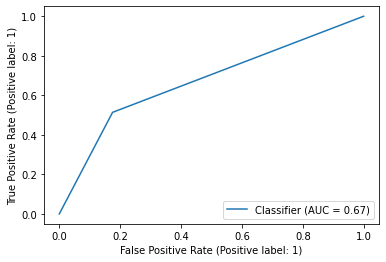

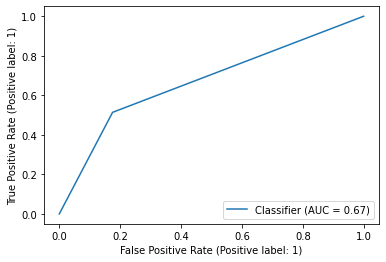

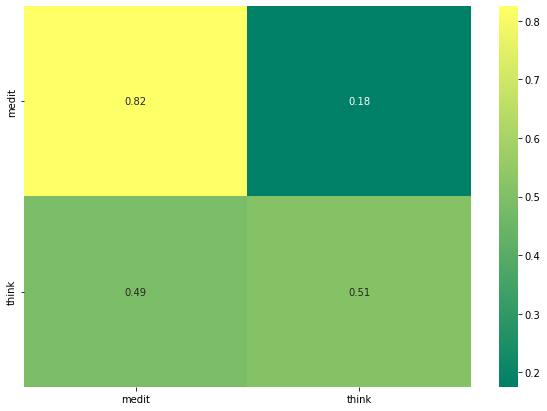

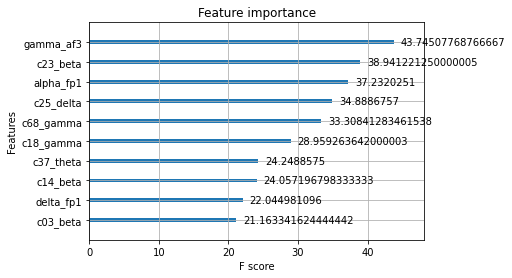

<Figure size 7200x7200 with 0 Axes>

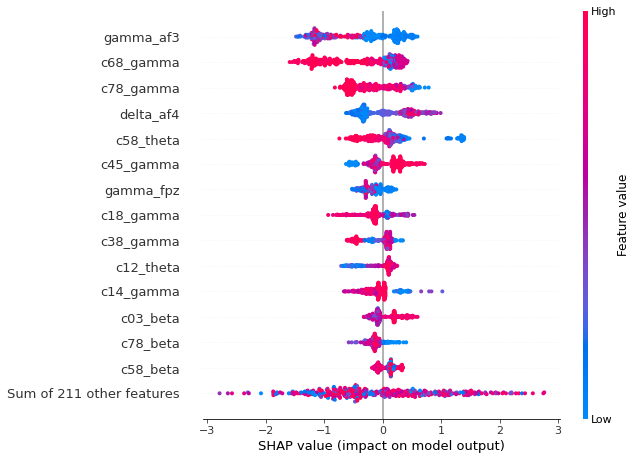

Aggregated scores after K-fold
AVG ACC SCORE: 0.694225301232899, full scores: [0.6752336448598131, 0.713216957605985]
AVG AUC-ROC SCORE: 0.6858914054680311, full scores: [0.7023870046239136, 0.6693958063121486]
AVG F1 SCORE: 0.5940372849046355, full scores: [0.6253369272237197, 0.5627376425855513]
########### XGBOOST #############
{'c78_gamma': 19, 'c03_gamma': 17, 'c58_theta': 17, 'c14_gamma': 14, 'c78_beta': 7, 'delta_af4': 6, 'c45_gamma': 6, 'c38_gamma': 5, 'c25_theta': 5, 'gamma_af4': 4, 'gamma_af3': 4, 'c68_gamma': 3, 'c12_theta': 2, 'gamma_fpz': 1}
########### SHAP #############
{'c78_gamma': 19, 'delta_af4': 17, 'c58_theta': 13, 'c68_gamma': 10, 'c14_gamma': 9, 'c78_beta': 7, 'c38_gamma': 7, 'c18_gamma': 7, 'c45_gamma': 6, 'c03_gamma': 5, 'gamma_fpz': 5, 'gamma_afz': 2, 'c12_theta': 2, 'beta_fp1': 1}
########### PERMUTATION ROC #############
{'c58_theta': 19, 'c03_beta': 15, 'delta_af4': 10, 'c08_gamma': 8, 'c12_beta': 8, 'c78_beta': 7, 'c45_gamma': 7, 'c58_beta': 6, 'c03_gamma'

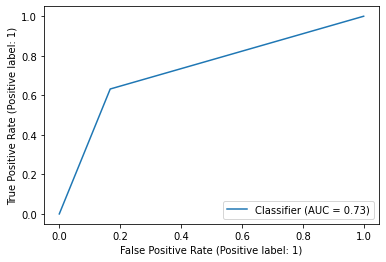

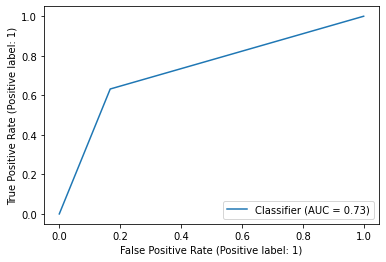

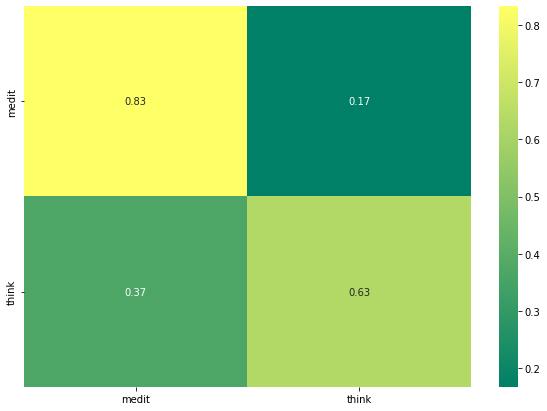

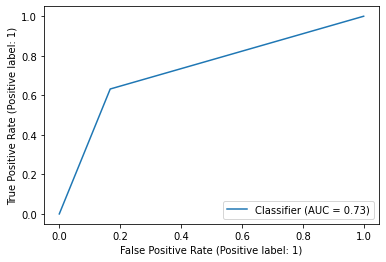

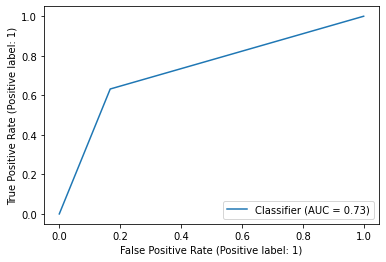

******* Dimensinality Reduction Results for  10 Top Features:  dict_keys(['c58_theta', 'delta_af4', 'c78_gamma', 'c03_gamma', 'c78_beta', 'c14_gamma', 'c03_beta', 'c68_gamma', 'c45_gamma', 'c12_beta'])
Aggregated scores after K-fold
AVG ACC SCORE: 0.7605985037406484, full scores: [0.7605985037406484, 0.7605985037406484]
AVG AUC-ROC SCORE: 0.7323146346735842, full scores: [0.7323146346735842, 0.7323146346735842]
AVG F1 SCORE: 0.6546762589928058, full scores: [0.6546762589928058, 0.6546762589928058]


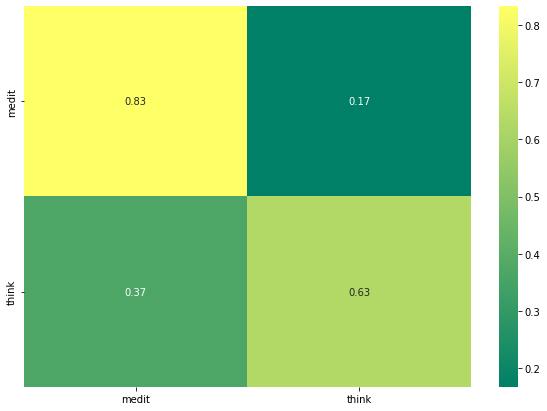

In [77]:
import statistics

xgb_weighted_scores = {}
shap_weighted_scores = {}
perm_weighted_scores_roc = {}
perm_weighted_scores_f1 = {}
auc_scores = []
f1_scores = []
acc_scores = []

for i in range(K):
  print(f"~~~~~~ running model for iteration #{i} ~~~~~~")
  (acc,auc,f1,xgb_imp,shap_imp,perm_imp_roc,perm_imp_f1) = runXgboost()
  
  # accumulate scores
  acc_scores.append(acc)
  auc_scores.append(auc)
  f1_scores.append(f1)

  # build important features dictionary
  for feature_index in range(top_features_count):
    addImportantFeature(list(xgb_imp.keys())[feature_index], xgb_weighted_scores, feature_index, top_features_count)
    addImportantFeature(shap_imp['col_name'].tolist()[feature_index], shap_weighted_scores, feature_index, top_features_count)
    addImportantFeature(list(perm_imp_roc.keys())[feature_index], perm_weighted_scores_roc, feature_index, top_features_count)
    addImportantFeature(list(perm_imp_f1.keys())[feature_index], perm_weighted_scores_f1, feature_index, top_features_count)

printAggregatedScores(acc_scores, auc_scores, f1_scores)

summed_importances = sumFeatureImportances(xgb_weighted_scores, shap_weighted_scores, perm_weighted_scores_roc, perm_weighted_scores_f1)
testDimensionalityReduction(summed_importances)